In [1]:
#Importing modules

from __future__ import print_function
import random 
from os import listdir
import glob 

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt

D:\_anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#setting dimensions for images from MNIST dataset

mnist_image_height = 28
mnist_image_width = 28

In [3]:
#Importing dataset from keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Shape of training dataset: (60000, 28, 28)
Shape of test dataset: (10000, 28, 28)


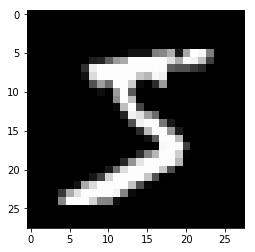

Label of x_train[0] = 5


In [4]:
print("Shape of training dataset: {}".format(np.shape(x_train)))
print("Shape of test dataset: {}".format(np.shape(x_test)))

#showing x_train[0]
plt.figure()
plt.imshow(x_train[0], cmap = "gray")
plt.show()

print("Label of x_train[0] = {}".format(y_train[0]))

# Creating a sequence of these digits 

In [5]:
def synth_data(data, labels, dataset_size):
    
    synth_img_height = 64
    synth_img_width = 64
    
    synth_data = np.ndarray(shape = (dataset_size, synth_img_height, synth_img_width), dtype = np.float32)
    
    synth_labels = []
    
    #looping over the no. of images we want 
    for i in range(dataset_size):
        
        #since we're not just doing 5-digit numbers, we'll be declaring number_of_digits
        num_digits = random.randint(1,5)
        
        #a list. picking random indices from dataset. 
        indices = [random.randint(0, len(data) - 1) for j in range(num_digits)]
        
        #stacking the images 
        new_image = np.hstack([x_train[index] for index in indices])
        
        #and now labels
        new_labels = [y_train[index] for index in indices]
        
        #to stack with blanks
        for blank in range(5 - num_digits):
            
            new_image = np.hstack([new_image, np.zeros(shape = (28, 28))]) #could use mnist_image_height/width over here 
            
            
        new_image = misc.imresize(new_image, (64,64))
        
        synth_data[i, :, :] = new_image
        
        synth_labels.append(tuple(new_labels))
        
    return synth_data, synth_labels
    

In [6]:
x_train_synth, y_train_synth = synth_data(x_train, y_train, 60000)

D:\_anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [7]:
x_test_synth, y_test_synth = synth_data(x_test, y_test, 10000)

D:\_anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


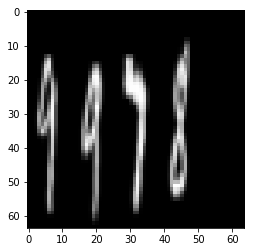

(9, 9, 7, 8)

In [8]:
plt.figure()
plt.imshow(x_train_synth[224], cmap='gray')
plt.show()

y_train_synth[224]

# Processing Labels
    
   This will be done using "One Hot" arrays

In [9]:
#number of classes 0-9 = 10
classes = 10 

def convert_labels(labels):
    
    #tp_categorical is in keras
    #Each digit array will be of shape (60000,10)
    
    #declaring arrays where we will (in the next "for" loop fill up with Hot Ones)
    digOneArr = np.ndarray(shape = (len(labels), classes))
    digTwoArr = np.ndarray(shape = (len(labels), classes))
    digThrArr = np.ndarray(shape = (len(labels), classes))
    digFouArr = np.ndarray(shape = (len(labels), classes))
    digFivArr = np.ndarray(shape = (len(labels), classes))
    
    #looping over individual labels to assign their digit values to the arrays
    for index, label in enumerate(labels):
        
        digOneArr[index, :] = np_utils.to_categorical(label[0], classes)
        digTwoArr[index, :] = np_utils.to_categorical(label[0], classes)
        digThrArr[index, :] = np_utils.to_categorical(label[0], classes)
        digFouArr[index, :] = np_utils.to_categorical(label[0], classes)
        digFivArr[index, :] = np_utils.to_categorical(label[0], classes)
    
    return [digOneArr, digTwoArr, digThrArr, digFouArr, digFivArr]

In [10]:
train_labels = convert_labels(y_train_synth)
test_labels = convert_labels(y_test_synth)

In [11]:
np_utils.to_categorical(y_train_synth[224][0],10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

# Preprocessing images for model

In [12]:
def prep_data_keras(img_data):
    
    #Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data),64,64,1)
    
    #Converting everything to floats
    img_data = img_data.astype('float32')
    
    #Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data

In [13]:
train_images = prep_data_keras(x_train_synth)
test_images = prep_data_keras(x_test_synth)

In [14]:
np.shape(train_images)

(60000, 64, 64, 1)

In [15]:
np.shape(test_images)

(10000, 64, 64, 1)

# The actual CNN model

In [16]:
#importing required dependencies 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D

Conv2D -> ReLu -> 2DMaxPooling -> dropout -> flattening layer -> softmax

In [34]:
def digitModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    ### START CODE HERE ###
    # Feel free to use the suggested outline in the text above to get started, and run through the whole
    # exercise (including the later portions of this notebook) once. The come back also try out other
    # network architectures as well. 
    X_input = Input(input_shape)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (3 , 3), strides = (1,1), border_mode = "same")(X_input)
    X = Activation('relu')(X)
    X = Conv2D(32, (3 , 3), strides = (1,1))(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    X = Dropout(0.5)(X)
    
    #5 digits
    d1 = Dense(10, activation='softmax')(X)
    d2 = Dense(10, activation='softmax')(X)
    d3 = Dense(10, activation='softmax')(X)
    d4 = Dense(10, activation='softmax')(X)
    d5 = Dense(10, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = [d1, d2, d3, d4, d5])
    
    return model

In [35]:
DigitModel = digitModel((64,64,1))

D:\_anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), strides=(1, 1), padding="same")`


In [36]:
DigitModel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
DigitModel.fit(x = train_images, y = train_labels, epochs = 12, batch_size = 128)

In [28]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        #Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter +=1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/50000.0
    global_accuracy = global_sequence_counter/10000.0
    
    return ind_accuracy,global_accuracy

In [29]:
predictions = DigitModel.predict(test_images)

In [30]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        #Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter +=1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/50000.0
    global_accuracy = global_sequence_counter/10000.0
    
    return ind_accuracy,global_accuracy

In [31]:
individual_acc, number_acc = calculate_acc(predictions,test_labels)

In [ ]:
print("The individual accuracy is {} %".format(individual_acc*100))
print("The sequence prediction accuracy is {} %".format(number_acc*100))